In [2]:
import requests
import pandas as pd
import numpy as np
import time
import scipy.stats as stats
import seaborn as sns
sns.set()

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

from sklearn.preprocessing import FunctionTransformer, StandardScaler 
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
GP_df = pd.read_csv('../Data/final_Data_for_Modeling.csv', parse_dates=['Date'])

GP_df['Gold_next'] = GP_df['Gold'].shift(periods=-1)
GP_df['Gold_1week'] = GP_df['Gold'].shift(periods=-5)
GP_df['Gold_4week'] = GP_df['Gold'].shift(periods=-28)
GP_df['Gold_prev'] = GP_df['Gold'].shift(periods=1)
# Gold percentge change (todays over previous close)
GP_df['Gold_chg'] = 100*(GP_df['Gold'] - GP_df['Gold_prev'])/GP_df['Gold_prev']
#
GP_df['GPInc'] = (GP_df['Gold_next']/GP_df['Gold']-1)
GP_df["year"]=pd.to_datetime(GP_df['Date'], format='%Y-%m-%d').dt.year - 2000

train_set_def = GP_df['year']<=15
test_set_def = (GP_df['year']>15) * (GP_df['year']<=16)

variables = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train = GP_df.loc[train_set_def, variables].copy()
y_train = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test = GP_df.loc[test_set_def, variables].copy()
y_test = GP_df.loc[test_set_def, 'Gold_next'].copy()

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [4]:
gp_train = GP_df['Gold']

In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(gp_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(gp_train.diff().dropna())
print('First diff: ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.873131
p-value: 0.796692
First diff: ADF Statistic: -14.950705
p-value: 0.000000


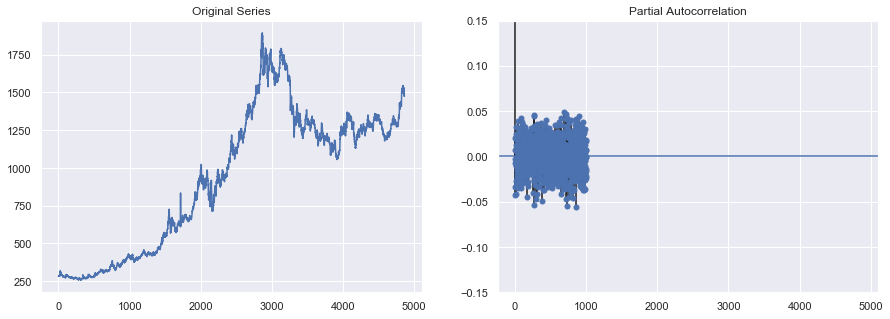

In [48]:
plt.rcParams['figure.figsize']=[15, 5]
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(gp_train); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,0.2))
plt.ylim(-0.15, .15)
plot_pacf(gp_train.diff().dropna(), ax=axes[1], lags = 10)
plt.show()

In [7]:
for i in range(1000,1020):
    print(i, gp_train.autocorr(lag=i))

1000 0.6063989485534679
1001 0.6059167142625548
1002 0.6054494656939772
1003 0.6050112565112141
1004 0.6045800840312765
1005 0.6041585763978128
1006 0.603743174463513
1007 0.6033232537907698
1008 0.60290585282907
1009 0.6024869856675237
1010 0.6020550928315747
1011 0.6016120333863848
1012 0.6011688291720394
1013 0.6007471851193164
1014 0.6003119664735865
1015 0.5998675136462717
1016 0.5994298492326201
1017 0.5989895037417694
1018 0.5985334380216669
1019 0.5980719148097366


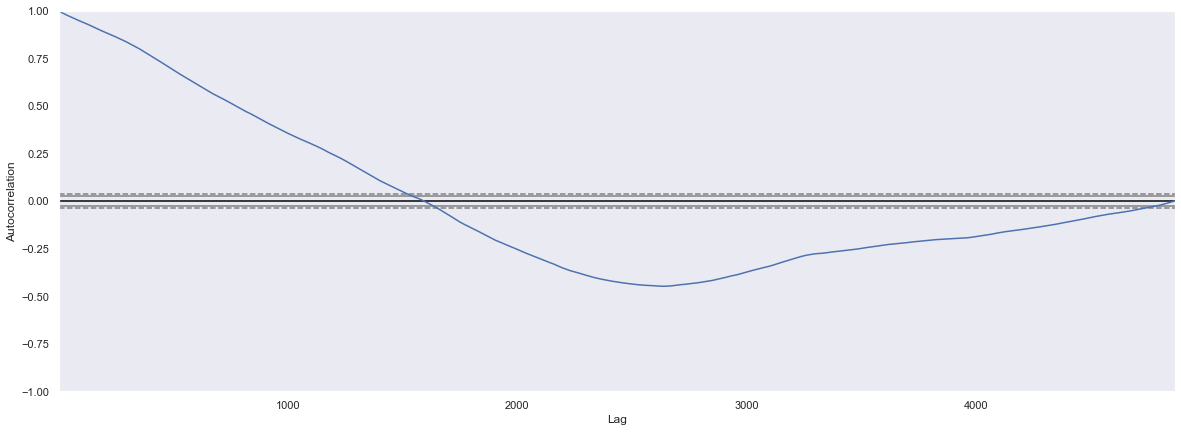

In [8]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(gp_train)
#plt.xlim(0,35);

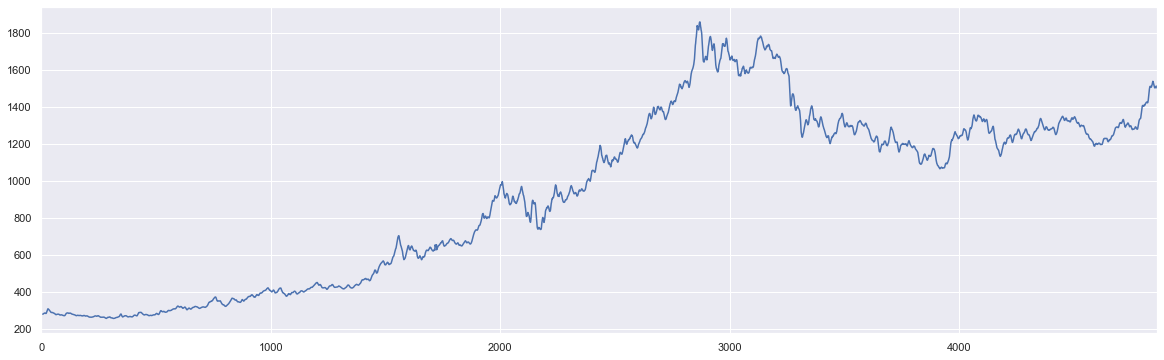

In [9]:
gp_train.rolling(7).mean().plot(figsize=(20,6));

In [18]:
train_set_def = GP_df['year']<=15
test_set_def = (GP_df['year']>15) * (GP_df['year']<=18)
small_test_def = (GP_df['year']>15) * (GP_df['year']<=16)

def return_tsGoldDF(xvars, trainSet, testSet):
    """
    """
    # --- by default y = "Gold"
    
    x_train = GP_df.loc[trainSet, xvars].dropna(axis=0).copy()
    y_train = GP_df.loc[trainSet, xvars + ['Gold']].dropna(axis=0)['Gold'].copy()

    x_test = GP_df.loc[testSet, xvars].dropna(axis=0).copy()
    y_test = GP_df.loc[testSet, xvars + ['Gold']].dropna(axis=0)['Gold'].copy()
    
    return x_train, x_test, y_train, y_test


x_vars1 = ['Silver', 'Platinum', 'OilSpot', \
             'DJI', 'TBill', 'FedFundRates', 'USDX']

x_train1, x_test1, y_train1, y_test1 = return_tsGoldDF(x_vars1, train_set_def, small_test_def)

sar = sm.tsa.statespace.SARIMAX(y_train1, order=(1,0,0), trend='ct', exog=x_train1).fit()
sar.summary()

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 3934
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -15299.737
Date:                Wed, 09 Oct 2019   AIC                          30621.473
Time:                        12:26:35   BIC                          30690.525
Sample:                             0   HQIC                         30645.971
                               - 3934                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.4113      0.641     -0.642      0.521      -1.667       0.844
drift            0.0009      0.000      6.089      0.000       0.001       0.001
Silver          28.9136      0.300     96.391      0.000      28.326      29.502
Platinum         0.0721      0.005     13.121      0.000       0.061       0.083
OilSpot          1.2348      0.106     11.635      0.000       1.027       1.443
DJI              0.0149      0.001     11.040      0.000       0.012       0.018
TBill         -103.6056      2.566    -40.369      0.000    -108.636     -98.575
FedFundRates   -14.9427      1.580     -9.460      0.000     -18.039     -11.847
USDX             4.1952      0.414     10.128      0.000       3.383       5.007
ar.L1            0.9879      0.002    625.505      0.000       0.985       0.991
sigma2         143.7575      3.215     44.712      0.000     137.456     150.059
===================================================================================
Ljung-Box (Q):                      240.13   Jarque-Bera (JB):            121713.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.45   Skew:                             1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
sar2 = sm.tsa.statespace.SARIMAX(y_train1, order=(2,0,0), trend='ct', exog=x_train1).fit(maxiter=200)
sar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 3934
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -14499.161
Date:                Wed, 09 Oct 2019   AIC                          29022.323
Time:                        12:25:45   BIC                          29097.651
Sample:                             0   HQIC                         29049.047
                               - 3934                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        2.1675      0.433      5.005      0.000       1.319       3.016
drift            0.0006      0.000      4.528      0.000       0.000       0.001
Silver          13.8466      0.113    122.242      0.000      13.625      14.069
Platinum         0.2369      0.002    101.642      0.000       0.232       0.241
OilSpot          0.6170      0.077      8.066      0.000       0.467       0.767
DJI              0.0117      0.001     14.427      0.000       0.010       0.013
TBill         -101.6608      1.631    -62.317      0.000    -104.858     -98.463
FedFundRates   -14.0307      0.901    -15.580      0.000     -15.796     -12.266
USDX             2.7352      0.254     10.756      0.000       2.237       3.234
ar.L1            0.8957      0.008    115.873      0.000       0.881       0.911
ar.L2            0.0957      0.008     12.388      0.000       0.081       0.111
sigma2          81.6351      0.971     84.061      0.000      79.732      83.538
===================================================================================
Ljung-Box (Q):                       60.02   Jarque-Bera (JB):              7811.95
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.66   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
ypred = sar.forecast(exog=x_test1)[0:12]
#y_train1, ypred

ValueError: Provided exogenous values are not of the appropriate shape. Required (1, 7), got (248, 7).

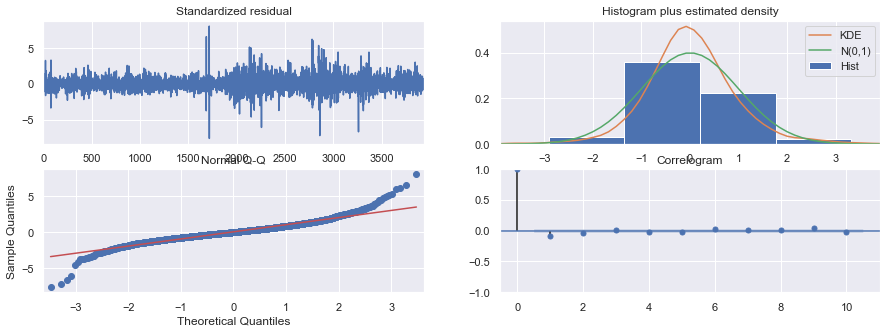

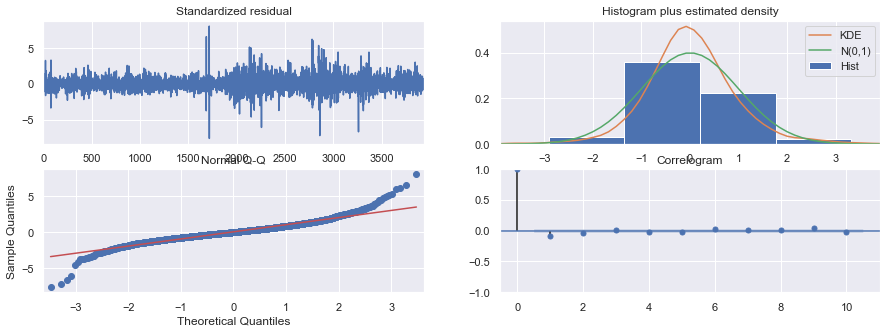

In [14]:
sar.plot_diagnostics()

In [37]:
gp_arima1 = sm.tsa.ARIMA(y_train1, order=[2,1,0])
arima1 = gp_arima1.fit()
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Gold   No. Observations:                 3933
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -15408.070
Method:                       css-mle   S.D. of innovations             12.167
Date:                Wed, 09 Oct 2019   AIC                          30824.139
Time:                        14:05:37   BIC                          30849.248
Sample:                             1   HQIC                         30833.047
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1985      0.178      1.116      0.265      -0.150       0.547
ar.L1.D.Gold    -0.0473      0.016     -2.968      0.003      -0.079      -0.016
ar.L2.D.Gold    -0.0430      0.016     -2.701      0.007      -0.074      -0.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5495           -4.7897j            4.8211           -0.2682
AR.2           -0.5495           +4.7897j            4.8211            0.2682
-----------------------------------------------------------------------------
"""

In [43]:
arima1.predict(start = 3000, end=3200)

3000    0.290472
3001    0.456288
3002    1.194374
3003   -0.246965
3004   -1.756527
          ...   
3196   -0.234954
3197   -0.649956
3198   -0.018254
3199    0.535837
3200   -0.334732
Length: 201, dtype: float64

In [58]:
from statsmodels.tsa.ar_model import AR
gp_ar = AR(y_train1)
ar1 = gp_ar.fit()
print('Lag: %s' % ar1.k_ar)
print('Coefficients: %s' % ar1.params)

Lag: 30
Coefficients: const       0.608601
L1.Gold     0.952093
L2.Gold     0.009063
L3.Gold     0.053242
L4.Gold    -0.015186
L5.Gold    -0.006162
L6.Gold     0.010155
L7.Gold    -0.010583
L8.Gold     0.024227
L9.Gold     0.025298
L10.Gold   -0.057068
L11.Gold   -0.026961
L12.Gold   -0.008320
L13.Gold    0.065360
L14.Gold   -0.011778
L15.Gold   -0.021809
L16.Gold    0.034213
L17.Gold   -0.021129
L18.Gold   -0.022971
L19.Gold    0.063595
L20.Gold   -0.009725
L21.Gold   -0.047082
L22.Gold   -0.004973
L23.Gold    0.032075
L24.Gold   -0.044230
L25.Gold    0.025342
L26.Gold   -0.024630
L27.Gold    0.037387
L28.Gold    0.000748
L29.Gold    0.020071
L30.Gold   -0.020705
dtype: float64


(3934,)
(3904,)
R-sqrd: 0.9993557563340438


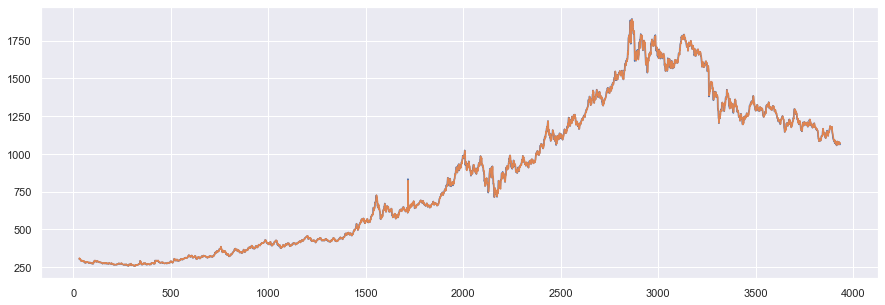

In [76]:
ay = ar1.predict(start=30, end=3933)
print(y_train1.shape)
print(ay.shape)
plt.plot(y_train1[30:])
plt.plot(ay)
#plt.xlim(1600, 1800)
print("R-sqrd: {}".format(r2_score(y_train1[30:], ay)))

(248,)


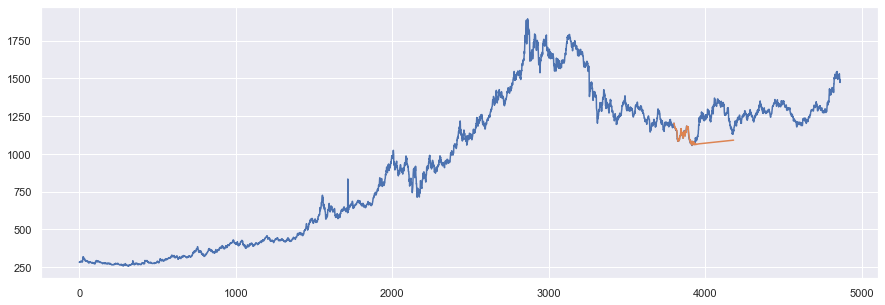

In [107]:
ay2 = ar1.predict(start=3800, end=4181, dynamic=False)
print(y_test1.shape)
plt.plot(GP_df['Gold'])
plt.plot(ay2)

In [90]:
gp_arima30 = sm.tsa.SARIMAX(y_train1, order=[30,0,0], trend='ct').fit()
gp_arima30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 3934
Model:              SARIMAX(30, 0, 0)   Log Likelihood              -15387.692
Date:                Wed, 09 Oct 2019   AIC                          30841.383
Time:                        15:41:44   BIC                          31048.538
Sample:                             0   HQIC                         30914.876
                               - 3934                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6005      0.547      1.098      0.272      -0.471       1.672
drift       5.369e-05      0.000      0.330      0.741      -0.000       0.000
ar.L1          0.9521      0.005    198.208      0.000       0.943       0.962
ar.L2          0.0091      0.013      0.697      0.486      -0.016       0.035
ar.L3          0.0532      0.018      2.954      0.003       0.018       0.089
ar.L4         -0.0152      0.019     -0.815      0.415      -0.052       0.021
ar.L5         -0.0062      0.017     -0.360      0.719      -0.040       0.027
ar.L6          0.0102      0.018      0.561      0.575      -0.025       0.046
ar.L7         -0.0106      0.016     -0.661      0.509      -0.042       0.021
ar.L8          0.0242      0.019      1.292      0.196      -0.013       0.061
ar.L9          0.0253      0.019      1.354      0.176      -0.011       0.062
ar.L10        -0.0571      0.018     -3.096      0.002      -0.093      -0.021
ar.L11        -0.0270      0.020     -1.382      0.167      -0.065       0.011
ar.L12        -0.0083      0.020     -0.418      0.676      -0.047       0.031
ar.L13         0.0654      0.021      3.172      0.002       0.025       0.106
ar.L14        -0.0118      0.020     -0.577      0.564      -0.052       0.028
ar.L15        -0.0218      0.019     -1.142      0.253      -0.059       0.016
ar.L16         0.0342      0.020      1.706      0.088      -0.005       0.074
ar.L17        -0.0211      0.020     -1.074      0.283      -0.060       0.017
ar.L18        -0.0230      0.017     -1.318      0.187      -0.057       0.011
ar.L19         0.0636      0.018      3.470      0.001       0.028       0.100
ar.L20        -0.0097      0.016     -0.619      0.536      -0.041       0.021
ar.L21        -0.0471      0.016     -2.859      0.004      -0.079      -0.015
ar.L22        -0.0050      0.017     -0.296      0.767      -0.038       0.028
ar.L23         0.0321      0.020      1.607      0.108      -0.007       0.071
ar.L24        -0.0442      0.021     -2.101      0.036      -0.085      -0.003
ar.L25         0.0253      0.019      1.308      0.191      -0.013       0.063
ar.L26        -0.0246      0.019     -1.266      0.206      -0.063       0.014
ar.L27         0.0374      0.017      2.167      0.030       0.004       0.071
ar.L28         0.0007      0.019      0.039      0.969      -0.037       0.039
ar.L29         0.0201      0.021      0.948      0.343      -0.021       0.062
ar.L30        -0.0208      0.015     -1.425      0.154      -0.049       0.008
sigma2       146.6297      0.875    167.510      0.000     144.914     148.345
===================================================================================
Ljung-Box (Q):                       10.73   Jarque-Bera (JB):            619025.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.46   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:       

In [165]:
gp_arima5 = sm.tsa.SARIMAX(y_train1, order=[5,0,0])#, trend='ct')
sarima5_results = gp_arima5.fit()
sarima5_results.summary()

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 3934
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -15462.727
Date:                Thu, 10 Oct 2019   AIC                          30937.454
Time:                        04:39:56   BIC                          30975.118
Sample:                             0   HQIC                         30950.816
                               - 3934                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9607      0.004    264.497      0.000       0.954       0.968
ar.L2         -0.0138      0.012     -1.181      0.238      -0.037       0.009
ar.L3          0.0439      0.016      2.676      0.007       0.012       0.076
ar.L4         -0.0093      0.017     -0.545      0.586      -0.043       0.024
ar.L5          0.0167      0.011      1.484      0.138      -0.005       0.039
sigma2       147.5192      0.712    207.149      0.000     146.123     148.915
===================================================================================
Ljung-Box (Q):                       73.25   Jarque-Bera (JB):            600741.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              24.51   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        63.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [176]:
sarima5_results.params

ar.L1       0.960672
ar.L2      -0.013756
ar.L3       0.043933
ar.L4      -0.009318
ar.L5       0.016660
sigma2    147.519249
dtype: float64

In [182]:
temp_y = pd.DataFrame(y_train1)
temp_y['pred']=sarima5_results.predict(start=0, end=3933)
temp_y
#plt.plot(temp_y['Gold'])
#plt.plot(temp_y['pred'])
for i in range(1,6):
    temp_y["lag"+str(i)] = temp_y['Gold'].shift(periods=i)
temp_y.head(20)

,Gold,pred,lag1,lag2,lag3,lag4,lag5
0,282.05,0.000000,NaN,NaN,NaN,NaN,NaN
1,282.10,281.479846,282.05,NaN,NaN,NaN,NaN
2,280.35,281.548041,282.10,282.05,NaN,NaN,NaN
3,282.10,279.892925,280.35,282.10,282.05,NaN,NaN
4,281.70,281.603348,282.10,280.35,282.10,282.05,NaN
5,282.25,281.127548,281.70,282.10,280.35,282.10,282.05
6,282.25,281.755443,282.25,281.70,282.10,280.35,282.10
7,282.20,281.684842,282.25,282.25,281.70,282.10,280.35
8,284.15,281.693854,282.20,282.25,282.25,281.70,282.10
9,286.85,283.556062,284.15,282.20,282.25,282.25,281.70


In [139]:
print((0.952961+0.004301+0.056940-0.014460-0.000535)*0.588522)

0.588055302054


In [183]:
temp_y['calc_pred'] = 0
params = sarima5_results.params
for i in range(1,6):
    temp_y['calc_pred'] += (temp_y['lag'+str(i)])*params[i-1]
#temp_y['calc_pred'] += params[0]
for i in range(1, 6):
    print(params[i-1])

temp_y['diff'] = temp_y['pred']-temp_y['calc_pred']
temp_y.tail(25)

0.9606715536516172
-0.013755925975011216
0.04393319965222834
-0.00931826229857932
0.016659908982187357


,Gold,pred,lag1,lag2,lag3,lag4,lag5,calc_pred,diff
3909,1076.40,1069.064567,1070.50,1085.15,1082.60,1070.50,1080.80,1069.064567,0.000000e+00
3910,1072.20,1074.761735,1076.40,1070.50,1085.15,1082.60,1070.50,1074.761735,0.000000e+00
3911,1064.65,1070.179956,1072.20,1076.40,1070.50,1085.15,1082.60,1070.179956,0.000000e+00
3912,1061.90,1063.422862,1064.65,1072.20,1076.40,1070.50,1085.15,1063.422862,2.273737e-13
3913,1069.25,1060.401308,1061.90,1064.65,1072.20,1076.40,1070.50,1060.401308,0.000000e+00
3914,1066.90,1067.305807,1069.25,1061.90,1064.65,1072.20,1076.40,1067.305807,0.000000e+00
3915,1055.45,1064.826688,1066.90,1069.25,1061.90,1064.65,1072.20,1064.826688,2.273737e-13
3916,1079.25,1054.082077,1055.45,1066.90,1069.25,1061.90,1064.65,1054.082077,0.000000e+00
3917,1082.70,1076.886018,1079.25,1055.45,1066.90,1069.25,1061.90,1076.886018,0.000000e+00
3918,1072.10,1079.514257,1082.70,1079.25,1055.45,1066.90,1069.25,1079.514257,0.000000e+00


In [198]:
type(sarima5_results)
sarima5_results.specification['order']
print(pd.DataFrame(y_train1).columns[0])

Gold


## Model #3a:  Time Series Forecasting

In [218]:
def sarima_test(sarima_results, test_set):
    order = sarima_results.specification['order']
    
    assert order[1] == 0
    assert order[2] == 0
    
    # --- Set variables needed for this method
    ar_p = order[0]
    params = sarima_results.params
    
    # --- Set the dataframe for the predictions calcs
    test = pd.DataFrame(test_set).copy()
    gold = test.columns[0]
    
    # --- create lagged golds
    for i in range(1, ar_p + 1):
        test["lag"+str(i)] = test[gold].shift(periods=i)
    
    # --- calc predictions
    test['pred'] = 0
    for i in range(1, ar_p + 1):
        # ---  prediction = lag1 * param[0] + lag2 * param[1] + ...
        test['pred'] += (test['lag'+str(i)])*params[i-1]
    
    return test[[gold, 'pred']]

# --- Unit test of the above function   
#test = sarima_test(sarima5_results, y_train1)
#test.tail(25)
# --- Unit test successful

In [225]:
lags = [3, 5, 10, 30]
rsqrs_lags = []
aics=[]
for lag in lags:
    gp_ar = sm.tsa.SARIMAX(y_train1, order=[lag,0,0])#, trend='ct')
    ar_results = gp_ar.fit()
    aics.append(ar_results.aic)
    
    preds = sarima_test(ar_results, y_train1[-lag:,].append(y_test1))[lag:]
    rsqrs_lags.append(r2_score(preds['Gold'], preds['pred']))

print(rsqrs_lags)

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anacon

[0.9716249372868586, 0.9703814120970244, 0.9683247582364864, 0.9691555723084271]


In [226]:
print(aics)

[30841.430696324904, 30937.453942739798, 31289.26371268156, 31059.516660593705]


In [228]:
gp_ar3 = sm.tsa.SARIMAX(y_train1, order=[3,0,0])#, trend='ct')
ar3_results = gp_ar3.fit()
ar3_results.summary()
preds = sarima_test(ar3_results, y_train1[-3:,].append(y_test1))[3:]

Naive solution R2: 0.97152412
Prediction solution R2: 0.97162494


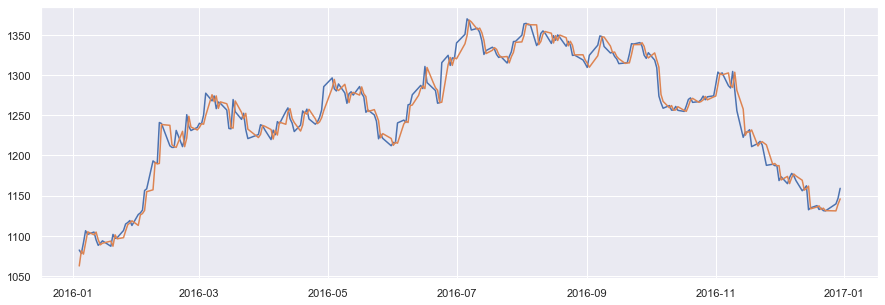

In [236]:
# --- Plot 1: On time axis
plt.rcParams['figure.figsize'] = [15, 5]
naive_r2 = r2_score(GP_df.loc[small_test_def, 'Gold_next'], GP_df.loc[small_test_def, 'Gold'])
print("Naive solution R2: {:.8f}".format(naive_r2))
pred_r2 = r2_score(preds['Gold'], preds['pred'])
print("Prediction solution R2: {:.8f}".format(pred_r2))

# Next day without Gold chg
plt.plot(GP_df.loc[small_test_def, 'Date'], GP_df.loc[small_test_def, 'Gold']);
# Next day gold predictions
plt.plot(GP_df.loc[small_test_def, 'Date'], preds['pred']);

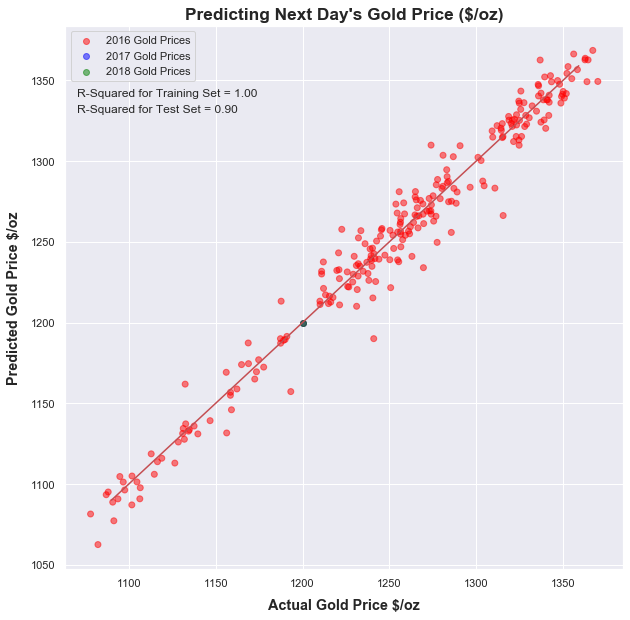

In [239]:
# --- Plot 2: Predictions vs Actual
colors = {16:'red', 17:'blue', 18:'green'}
cols = GP_df.loc[small_test_def, 'year'].apply(lambda x: colors[x])


plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(preds['Gold'], [preds['pred']], c = cols, alpha=0.5);

for i in range(16,19):
    plt.scatter(1200, 1200, c = colors[i], alpha=0.5, label = "20{} Gold Prices".format(i));


x_fit_line=[x for x in range(1090, 1360)]
plt.plot(x_fit_line, x_fit_line, c="r",)
plt.xlabel("Actual Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.ylabel("Predicted Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.title("Predicting Next Day's Gold Price ($/oz)", fontweight='bold', fontsize = 'xx-large')
plt.text(1070, 1340, "R-Squared for Training Set = 1.00", fontsize=12)
plt.text(1070, 1330, "R-Squared for Test Set = 0.90", fontsize=12)
plt.legend();

## Model #3b:  Time Series Forecasting of Log(Gold Price)

In [248]:
logy_train = pd.Series(np.log(y_train1))
logy_test = pd.Series(np.log(y_test1))

In [258]:
lags = [1, 3, 5, 10, 30]
rsqrs_lags = []
aics=[]
for lag in lags:
    gp_ar = sm.tsa.SARIMAX(logy_train, order=[lag,0,0])#, trend='ct')
    ar_results = gp_ar.fit()
    aics.append(ar_results.aic)
    
    preds = sarima_test(ar_results, logy_train[-lag:,].append(logy_test))[lag:]
    rsqrs_lags.append(r2_score(preds['Gold'], preds['pred']))

print(rsqrs_lags)

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anacon

[0.9725006844662685, 0.972104597749127, 0.9448134687847571, 0.9399885609933822, 0.8413669286530262]


In [259]:
print(aics)

[-22944.47454395884, -22951.82160977329, -20686.87363003728, -20114.591807590587, -16671.260225013342]


In [251]:
gp_ar3log = sm.tsa.SARIMAX(logy_train, order=[3,0,0])#, trend='ct')
ar3log_results = gp_ar3log.fit()
ar3log_results.summary()
preds = sarima_test(ar3log_results, logy_train[-3:,].append(logy_test))[3:]

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [252]:
ar3log_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 3934
Model:               SARIMAX(3, 0, 0)   Log Likelihood               11479.911
Date:                Thu, 10 Oct 2019   AIC                         -22951.822
Time:                        06:24:37   BIC                         -22926.712
Sample:                             0   HQIC                        -22942.913
                               - 3934                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9259      0.003    334.344      0.000       0.921       0.931
ar.L2          0.0870      0.014      6.090      0.000       0.059       0.115
ar.L3         -0.0130      0.015     -0.870      0.384      -0.042       0.016
sigma2         0.0002   7.92e-07    229.590      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       74.03   Jarque-Bera (JB):           3211550.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                       142.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Naive solution R2: 0.97152412
Prediction solution R2: 0.97125190


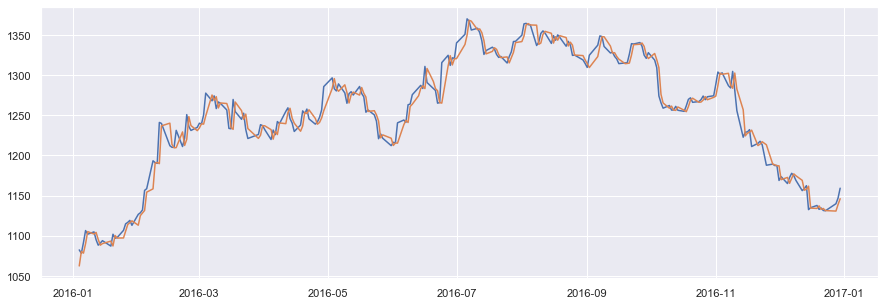

In [256]:
# --- Plot 1: On time axis
plt.rcParams['figure.figsize'] = [15, 5]
naive_r2 = r2_score(GP_df.loc[small_test_def, 'Gold_next'], GP_df.loc[small_test_def, 'Gold'])
print("Naive solution R2: {:.8f}".format(naive_r2))
pred_r2 = r2_score(np.exp(preds['Gold']), np.exp(preds['pred']))
print("Prediction solution R2: {:.8f}".format(pred_r2))

# Next day without Gold chg
plt.plot(GP_df.loc[small_test_def, 'Date'], GP_df.loc[small_test_def, 'Gold']);
# Next day gold predictions
plt.plot(GP_df.loc[small_test_def, 'Date'], np.exp(preds['pred']));

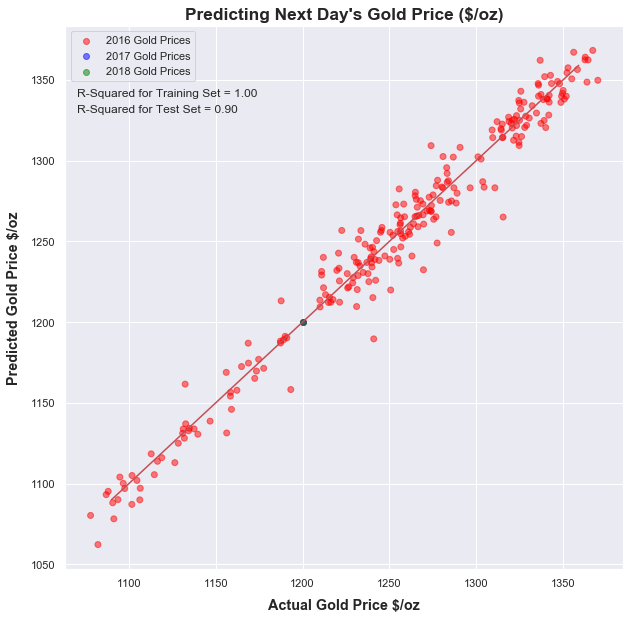

In [257]:
# --- Plot 2: Predictions vs Actual
colors = {16:'red', 17:'blue', 18:'green'}
cols = GP_df.loc[small_test_def, 'year'].apply(lambda x: colors[x])


plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(np.exp(preds['Gold']), np.exp(preds['pred']), c = cols, alpha=0.5);

for i in range(16,19):
    plt.scatter(1200, 1200, c = colors[i], alpha=0.5, label = "20{} Gold Prices".format(i));


x_fit_line=[x for x in range(1090, 1360)]
plt.plot(x_fit_line, x_fit_line, c="r",)
plt.xlabel("Actual Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.ylabel("Predicted Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.title("Predicting Next Day's Gold Price ($/oz)", fontweight='bold', fontsize = 'xx-large')
plt.text(1070, 1340, "R-Squared for Training Set = 1.00", fontsize=12)
plt.text(1070, 1330, "R-Squared for Test Set = 0.90", fontsize=12)
plt.legend();

In [260]:
gp_ar5log = sm.tsa.SARIMAX(logy_train, order=[5,0,0])#, trend='ct')
ar5log_results = gp_ar5log.fit()
ar5log_results.summary()
preds = sarima_test(ar5log_results, logy_train[-5:,].append(logy_test))[5:]

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [261]:
ar5log_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 3934
Model:               SARIMAX(5, 0, 0)   Log Likelihood               10349.437
Date:                Thu, 10 Oct 2019   AIC                         -20686.874
Time:                        06:47:07   BIC                         -20649.209
Sample:                             0   HQIC                        -20673.511
                               - 3934                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1815      0.010     18.631      0.000       0.162       0.201
ar.L2          0.8318      0.005    167.611      0.000       0.822       0.842
ar.L3          0.1492      0.013     11.268      0.000       0.123       0.175
ar.L4         -0.4769      0.006    -80.795      0.000      -0.489      -0.465
ar.L5          0.3140      0.008     37.620      0.000       0.298       0.330
sigma2         0.0003   1.99e-06    153.665      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      772.72   Jarque-Bera (JB):            409102.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.16
Prob(H) (two-sided):                  0.05   Kurtosis:                        52.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Naive solution R2: 0.97152412
Prediction solution R2: 0.94309606


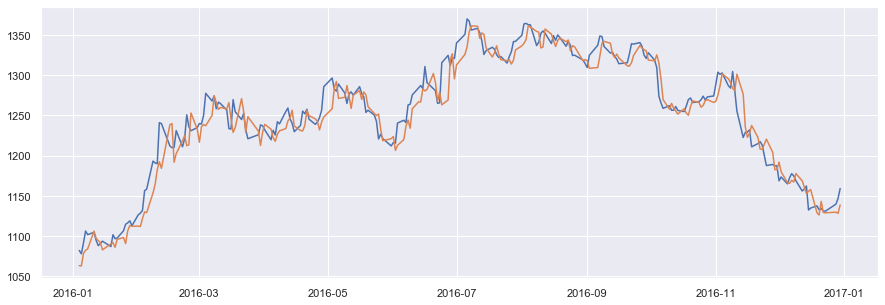

In [262]:
# --- Plot 1: On time axis
plt.rcParams['figure.figsize'] = [15, 5]
naive_r2 = r2_score(GP_df.loc[small_test_def, 'Gold_next'], GP_df.loc[small_test_def, 'Gold'])
print("Naive solution R2: {:.8f}".format(naive_r2))
pred_r2 = r2_score(np.exp(preds['Gold']), np.exp(preds['pred']))
print("Prediction solution R2: {:.8f}".format(pred_r2))

# Next day without Gold chg
plt.plot(GP_df.loc[small_test_def, 'Date'], GP_df.loc[small_test_def, 'Gold']);
# Next day gold predictions
plt.plot(GP_df.loc[small_test_def, 'Date'], np.exp(preds['pred']));